# Visualing portfolio performance

In [3]:
import sys
sys.path.append("../../src")

from src.config import app_config
from sqlalchemy import create_engine
from sqlalchemy.orm import Session

ENGINE  = create_engine(app_config.SQLALCHEMY_DATABASE_URI, echo=False, pool_size=20, max_overflow=0)

In [3]:
from src.service import DataService
from src.model import PortfolioHistoryModel, BalanceHistoryModel
import matplotlib.pyplot as plt

### Matplotlib

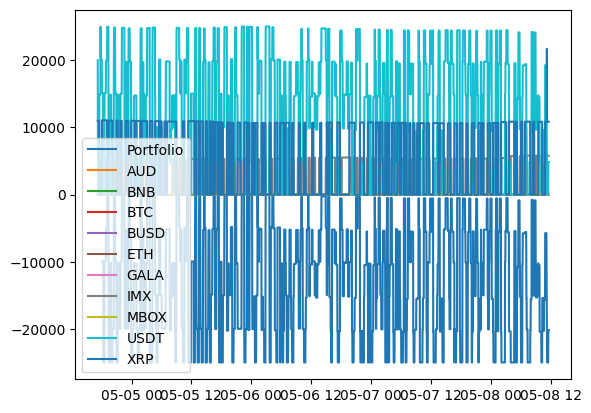

In [7]:
with Session(ENGINE) as session:
    portfolio = DataService().get_portfolio(session, 10)
    portfolio_history: list[PortfolioHistoryModel] = DataService().get_portfolio_history(session, portfolio.id)
    plt.plot([h.created_at for h in portfolio_history], [h.total_earnings for h in portfolio_history], label="Portfolio")

    balances = portfolio.balances

    # plot the history for each balance
    for balance in balances:
        balance_history: list[BalanceHistoryModel] = DataService().get_balance_history(session, balance.id)
        plt.plot([h.created_at for h in balance_history], [h.total for h in balance_history], label=balance.asset)

    plt.legend()
    plt.show()


### Bokeh

In [4]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.palettes import Category10, Dark2_5
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [11]:
with Session(ENGINE) as session:
    portfolio = DataService().get_portfolio(session, 2)
    portfolio_history: list[PortfolioHistoryModel] = DataService().get_portfolio_history(session, portfolio.id)
    x = [h.created_at for h in portfolio_history]
    y = [h.total_earnings for h in portfolio_history]
    source = ColumnDataSource(data=dict(x=x, y=y))
    p = figure(width=800, height=400, x_axis_type="datetime")
    # p.line(x="x", y="y", source=source, line_width=2, legend_label="Portfolio")
    p.add_tools(HoverTool(
        tooltips=[
            ('date', '@x{%F}'),
            ('value', '@y{0.0000}'),
        ],
        formatters={
            '@x': 'datetime',
        },
        mode='vline'
    ))

    balances = portfolio.balances

    # plot the history for each balance
    for i, balance in enumerate(balances):

        balance_history: list[BalanceHistoryModel] = DataService().get_balance_history(session, balance.id)
        x = [h.created_at for h in balance_history]
        y = [h.total for h in balance_history]
        source = ColumnDataSource(data=dict(x=x, y=y))
        p.line(x="x", y="y", source=source, line_width=2, color=Category10[10][i], legend_label=balance.asset)
        p.add_tools(HoverTool(
            tooltips=[
                ('date', '@x{%F}'),
                ('value', '@y{0.0000}'),
            ],
            formatters={
                '@x': 'datetime',
            },
            mode='vline'
        ))

    # Hide lines on click
    p.legend.click_policy = "hide"

    show(p)


In [98]:
from src.service import DataService
with Session(ENGINE) as session:
    portfolios = DataService().get_portfolios(session)
    for portfolio in portfolios:
        print(f"id: {portfolio.id} - P/L: {portfolio.total_earnings}")

id: 1 - P/L: -1000.0
id: 2 - P/L: -150.76740705
id: 3 - P/L: -309.46560926
id: 4 - P/L: -5316.80758374
id: 5 - P/L: -15373.23696848
id: 6 - P/L: -11220.88192635
id: 7 - P/L: -5774.75324228
id: 8 - P/L: 0.0
id: 9 - P/L: 0.0
id: 10 - P/L: -25000.00000004
id: 11 - P/L: -1223.94673288
id: 12 - P/L: 0.0
id: 13 - P/L: 0.0
id: 14 - P/L: -10114.98510663
id: 15 - P/L: -68.89160894
id: 16 - P/L: -5219.76820468
id: 17 - P/L: -15068.90380111
id: 18 - P/L: -10000.0
id: 19 - P/L: -5058.37562142
id: 20 - P/L: 0.0
id: 21 - P/L: 0.0
id: 22 - P/L: 0.0
id: 23 - P/L: -10062.34369339
id: 24 - P/L: -20083.62688567
id: 25 - P/L: -20138.03474567
id: 26 - P/L: -19868.94388602
id: 27 - P/L: -378.42085352
id: 28 - P/L: -25000.00000001
id: 29 - P/L: -25000.0
id: 30 - P/L: -25000.0
id: 31 - P/L: -25000.0
id: 32 - P/L: -10156.86785853
id: 33 - P/L: -9721.19129153
id: 34 - P/L: 0.0
id: 35 - P/L: -9763.77749022
id: 36 - P/L: -19950.29842508
id: 37 - P/L: -5000.0
id: 38 - P/L: -5318.2042458
id: 39 - P/L: -10314.267521

In [5]:
from src.service import DataService
from src.model import CurrencyPairConfigModel, OrderModel
from src.enums import OrderSide

with Session(ENGINE) as session:
    users = DataService().get_users(session)
    for user in users:
        bots = user.currency_pair_configs
        profit = 0
        for bot in bots:
            orders = bot.orders
            if len(orders) == 0:
                continue

            latest_order: OrderModel = orders[-1]            
            if latest_order.side.value == OrderSide.BUY.value:
                profit += latest_order.cost - bot.allocated_balance
            else:
                profit += latest_order.amount - bot.allocated_balance
        
        print(f"User Id: {user.id} | Strategy: {bots[0].strategy.value} | Interval: {bots[0].interval.value} - P/L: {profit}") if profit > 0 else None

User Id: 1 | Strategy: Bollinger Bands | Interval: 1m - P/L: 3.7841064699999833
User Id: 23 | Strategy: Relative Strength Index | Interval: 1m - P/L: 646.06069948
User Id: 24 | Strategy: Chaikin Oscillator | Interval: 1m - P/L: 341.56766072999926
User Id: 25 | Strategy: Chaikin Oscillator | Interval: 3m - P/L: 86.67883330999939
User Id: 26 | Strategy: Chaikin Oscillator | Interval: 5m - P/L: 253.45841975000076
User Id: 28 | Strategy: Chaikin Oscillator | Interval: 30m - P/L: 789.1120827499999
User Id: 32 | Strategy: Commodity Channel Index | Interval: 1m - P/L: 437.4324791500003
User Id: 33 | Strategy: Commodity Channel Index | Interval: 5m - P/L: 538.2553007600009
User Id: 35 | Strategy: Commodity Channel Index | Interval: 30m - P/L: 490.1715851399995
User Id: 36 | Strategy: Commodity Channel Index | Interval: 1h - P/L: 477.74302438999985
User Id: 37 | Strategy: Commodity Channel Index | Interval: 2h - P/L: 96.40561771000012
User Id: 44 | Strategy: Chaikin Oscillator | Interval: 15m -

### Bot performance

In [12]:
from src.model import CurrencyPairConfigModel, OrderModel
from src.enums import OrderSide
import itertools

user_id = 23
colors = itertools.cycle(Dark2_5)# create a color iterator
with Session(ENGINE) as session:
    user = DataService().get_user(session, user_id)
    bots: list[CurrencyPairConfigModel] = user.currency_pair_configs
    print("=====================================")
    print(f"User: {user.email}")
    print(f"Bot: {bots[0].id} - {bots[0].currency_pair} - {bots[0].strategy.value} - {bots[0].interval.value}")
    print(bots[0].strategy_config)

    # Plot the history of orders for each bot in bokeh
    p = figure(width=1200, height=800, x_axis_type="datetime")
    for i, bot in enumerate(bots):
        orders: list[OrderModel] = bot.orders
        x = [o.created_at for o in orders if o.side.value == OrderSide.BUY.value]
        y_currency = [o.cost for o in orders if o.side.value == OrderSide.BUY.value]
        
        divisor = len(y_currency) if len(y_currency) > 0 else 1
        print(sum(y_currency) / divisor)
        # print(sum(y_currency) / len(y_currency))
        # y_asset = [o.amount for o in orders if o.side.value == "Buy"]
        # source = ColumnDataSource(data=dict(x=x, y=y_asset))
        # p.line(x="x", y="y", source=source, line_width=2, color=Category10[10][i], legend_label=bot.bot_name + " - asset")
        source = ColumnDataSource(data=dict(x=x, y=y_currency))
        p.line(x="x", y="y", source=source, line_width=2, color=next(colors), legend_label=bot.bot_name + " - currency")

    p.add_tools(HoverTool(
        tooltips=[
            ('date', '@x{%F}'),
            ('value', '@y{0.0000}'),
        ],
        formatters={
            '@x': 'datetime',
        },
        mode='vline'
    ))

    # Hide lines on click
    p.legend.click_policy = "hide"

    show(p)


User: bot23@admin.com
Bot: 111 - BNBUSDT - Relative Strength Index - 1m
[
            StrategyConfigModel(
                id=207,
                currency_pair_config_id=111,
                strategy=StrategyType.RSI,
                key=window,
                value=1
            )
        ]
5143.075138134545
4951.472245664489
4913.146152316581
5204.919966407285
4908.0536127714695


### Plotting currently profitable bots

In [4]:
import itertools
from src.service import DataService
from src.model import CurrencyPairConfigModel, OrderModel

with Session(ENGINE) as session:
    bots = DataService().get_active_bots(session)
    print(len(bots))

197


In [8]:


# Plot the history of orders for each bot in bokeh
p = figure(width=1200, height=800, x_axis_type="datetime")
with Session(ENGINE) as session:
    bots = DataService().get_bots(session)
    colors = itertools.cycle(Dark2_5)# create a color iterator 
    for i, bot in enumerate(bots):
        orders: list[OrderModel] = bot.orders
        x = [o.created_at for o in orders if o.side.value == OrderSide.BUY.value]
        y_currency = [o.cost for o in orders if o.side.value == OrderSide.BUY.value]
        divisor = len(y_currency) if len(y_currency) > 0 else 1
        avg = sum(y_currency) / divisor
        if avg < bot.allocated_balance:
            continue

        print(f"Bot: {bot.id} - {bot.currency_pair} - {bot.strategy.value} - avg {avg}") if avg > 5100 else None
        
        source = ColumnDataSource(data=dict(x=x, y=y_currency))
        p.line(x="x", y="y", source=source, line_width=2, color=next(colors), legend_label=bot.bot_name, name=bot.bot_name)

    session.commit()

p.add_tools(HoverTool(
    tooltips=[
        ('bot', '$name'),
        ('date', '@x{%F}'),
        ('value', '@y{0.0000}'),
    ],
    formatters={
        '@x': 'datetime',
    },
    mode='vline'
))


# Hide lines on click
p.legend.click_policy = "hide"
p.legend.label_text_font_size = "8pt"
p.legend.location = "bottom_left"
p.legend.orientation = "vertical"
new_legend = p.legend[0]
p.legend[0] = None
p.add_layout(new_legend, 'right')


show(p)


Bot: 78 - ETHUSDT - Commodity Channel Index - avg 5105.980202838
Bot: 109 - IMXUSDT - Relative Strength Index - avg 5210.92241820646
Bot: 111 - BNBUSDT - Relative Strength Index - avg 5144.447188809196
Bot: 112 - BTCUSDT - Chaikin Oscillator - avg 5116.6807264062245
Bot: 114 - IMXUSDT - Chaikin Oscillator - avg 5109.288539846
Bot: 119 - IMXUSDT - Chaikin Oscillator - avg 5167.320206139143
Bot: 122 - BTCUSDT - Chaikin Oscillator - avg 5136.391035594674
Bot: 123 - ETHUSDT - Chaikin Oscillator - avg 5106.841605533564
Bot: 125 - XRPUSDT - Chaikin Oscillator - avg 5104.017976259718
Bot: 134 - IMXUSDT - Chaikin Oscillator - avg 5217.501025901924
Bot: 154 - IMXUSDT - Commodity Channel Index - avg 5438.198175829332
Bot: 158 - ETHUSDT - Commodity Channel Index - avg 5138.802543491785
Bot: 168 - ETHUSDT - Commodity Channel Index - avg 5142.699964555455
Bot: 218 - CFXUSDT - Chaikin Oscillator - avg 5123.682844712858
Bot: 230 - TRUUSDT - Chaikin Oscillator - avg 5450.284775651251
Bot: 235 - BELUSD

In [12]:
show(p)